<a href="https://colab.research.google.com/github/Science-Master/UCI-CVD_CNN/blob/main/CNN_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install lime

In [167]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
# Libraries for data manipulation
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Libraries for PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Explainability libraries
import shap
import lime
import lime.lime_tabular

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Other libraries
import copy
import time
import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


Load dataset from google drive

In [169]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/heart_failure_clinical_records_dataset-1-1.csv')
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


Getting to understand data with some basic statistical metrics

In [170]:
# Check out data types, missing values and more
data.info()

print()
print(f'Shape of the dataset')
print(f'Number of Features: {data.shape[1]}')
print(f'Number of Observations: {data.shape[0]}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB

Shape of the data

In [171]:
# Check missing values
data.isnull().sum()

,0
age,0
anaemia,0
creatinine_phosphokinase,0
diabetes,0
ejection_fraction,0
high_blood_pressure,0
platelets,0
serum_creatinine,0
serum_sodium,0
sex,0


In [172]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


In [197]:
# Step 2: Check for duplicates
duplicate_rows = data.duplicated().sum()
duplicate_rows

0

In [198]:
# Step 3: Detect outliers (using IQR for continuous variables)
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()

outliers

,0
age,0
anaemia,0
creatinine_phosphokinase,29
diabetes,0
ejection_fraction,2
high_blood_pressure,0
platelets,21
serum_creatinine,29
serum_sodium,4
sex,0


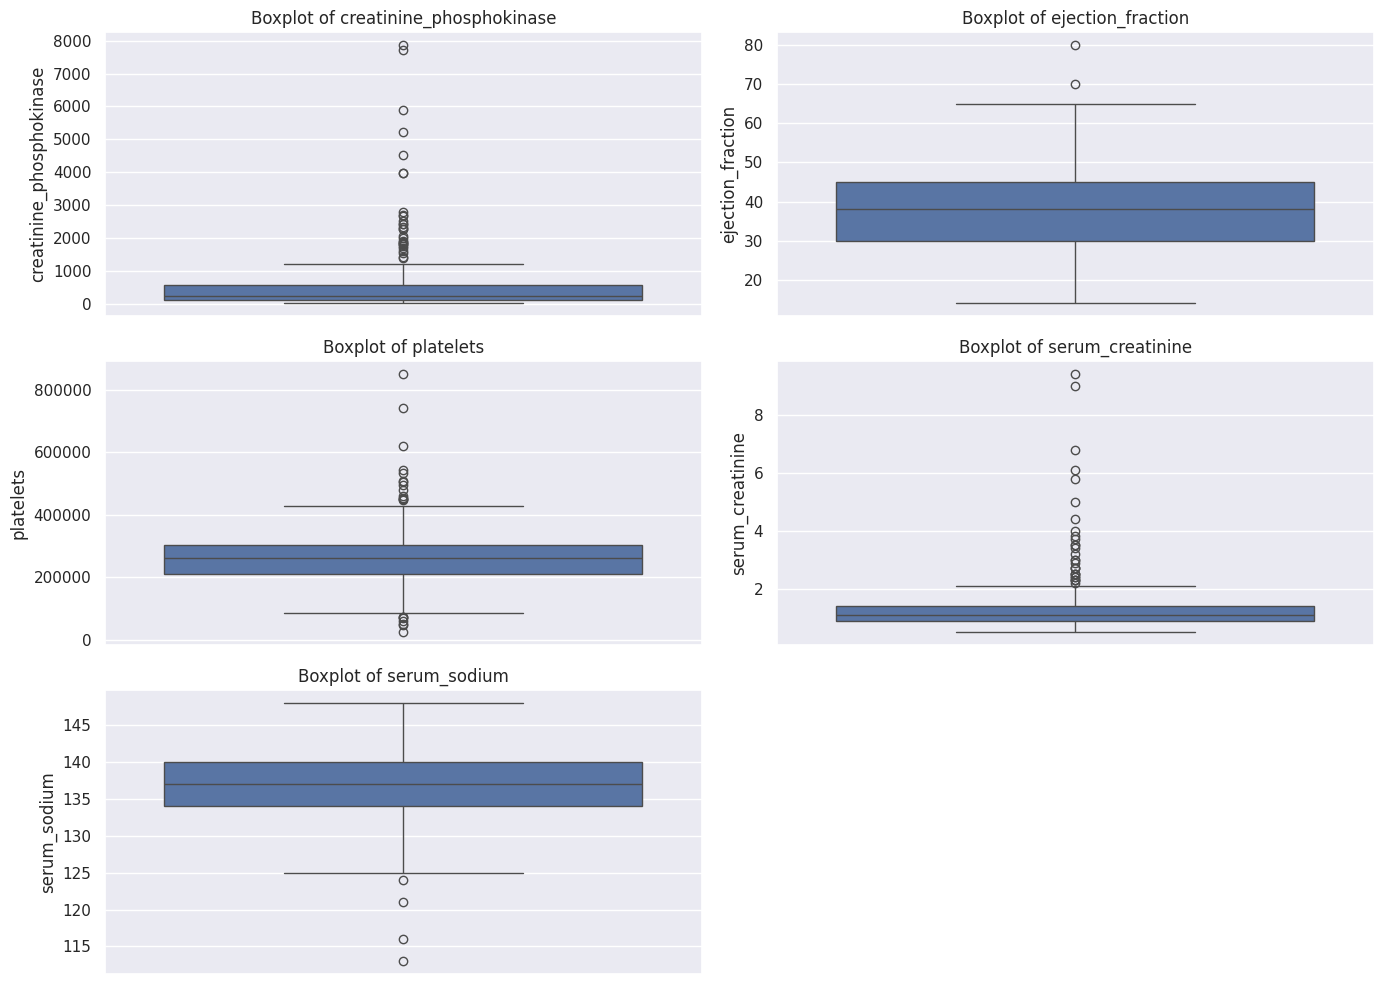

In [200]:

# List of columns with identified outliers
columns_with_outliers = ['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']

# Set up the figure and axes
plt.figure(figsize=(14, 10))

# Loop through the columns and create boxplots to visualize outliers
for i, col in enumerate(columns_with_outliers, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


# **Exploratory Data Analysis (EDA)**

In [173]:
# Count of Death Event in Dataset (1 meaning Death Event occured and 0 means Death Event did not happen)
results = data['DEATH_EVENT'].value_counts()
results

,count
DEATH_EVENT,
0,203
1,96


In [174]:
import seaborn as sns
sns.set(style='darkgrid')
import plotly.graph_objs as go
import plotly.offline as py

def condition_ratio(data):
    """
    Make a pie chart of the Target 'DEATH_EVENT' values
    Condition: 0 = Benign, 1 = Malignant
    """
    results = data['DEATH_EVENT'].value_counts()
    values = [results[0], results[1]]
    labels = ['Not Death Event', 'Death Event']
    colors = ['MediumSeaGreen', 'Coral']

    fig_pie = go.Pie(labels=labels, values=values,
                     marker={'colors': colors,
                             'line': {'color': 'Black', 'width': 2}})
    py.iplot([fig_pie])
    return py


condition_ratio(data);

Observations from above is that
67.9% of the time, patients did not have a cardiovascular disease. On the otherhand,
patients did have a cardiovascular disease 32.1% of the time

In [175]:
def sex_ratio(data):
    """
    Make a pie chart of 'Sex' values
    Sex: 0 = Female, 1 = Male
    """
    # Pie chart of sex ratio
    results = data['sex'].value_counts()
    values = [results[0], results[1]]
    labels = ['Female', 'Male']
    colors = ['MediumSeaGreen', 'Coral']

    fig_pie = go.Pie(labels=labels, values=values,
                     marker={'colors': colors,
                             'line': {'color': 'Black', 'width': 2}})
    py.iplot([fig_pie])
    return py


sex_ratio(data);

 **Observations**

The data is made up of a significantly huge amount of males compered to females ( Male population of 64.9% against a Female population of

In [179]:
#Count of Males and Females against Target Variable(DEATH_EVENT)
data.groupby('sex')['DEATH_EVENT'].value_counts()

sex  DEATH_EVENT
0    0               71
     1               34
1    0              132
     1               62
Name: count, dtype: int64

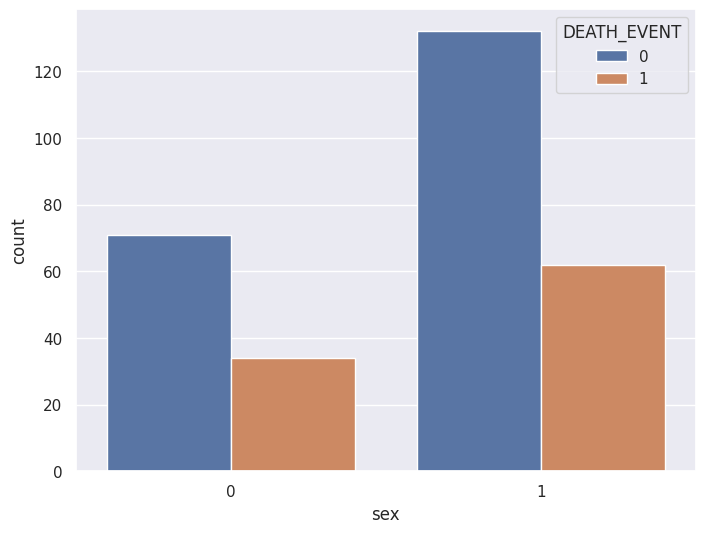

In [176]:
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x="sex", hue="DEATH_EVENT", data=data)
plt.show()

**Interpretation**

We can see that the values of target variable (Death Event) are plotted agianst sex : ( 0 = Female, 1 = Male).

target variable Death Event variable also contains two integer values 1 and 0 : (1 = Presence of heart disease; 0 = Absence of heart disease)

The above plot confirms our findings that -

Out of 105 females - 34 have heart disease and 71 do not have heart disease.

Similarly, out of 194 males - 62 have heart disease and 132 do not have heart disease.

<ipython-input-180-71314b8d06a8>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




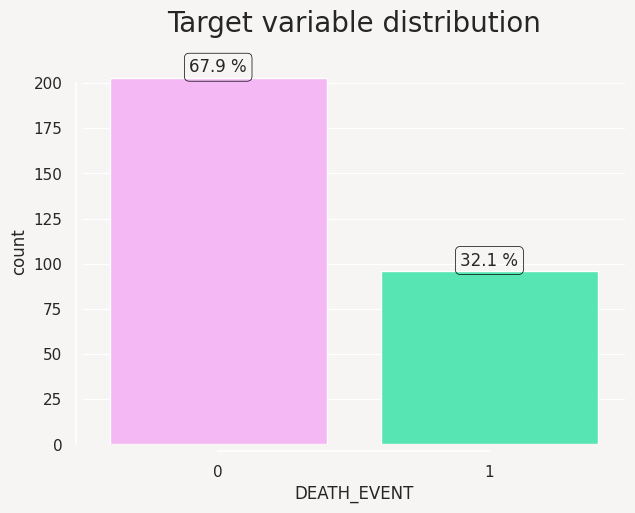

In [180]:
mypal= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA']

plt.figure(figsize=(7, 5),facecolor='#F6F5F4')
total = float(len(data))
ax = sns.countplot(x=data['DEATH_EVENT'], palette=mypal[1::4])
ax.set_facecolor('#F6F5F4')

for p in ax.patches:

    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.1f} %'.format((height/total)*100), ha="center",
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

ax.set_title('Target variable distribution', fontsize=20, y=1.05)
sns.despine(right=True)
sns.despine(offset=5, trim=True)

# Findings of Univariate Analysis
Findings of univariate analysis are as follows:-

Our feature variable of interest is DEATH_EVENT.

It refers to the presence of heart disease in the patient.

It is integer value as it contains two integers 0 and 1 - (0 stands for absence of heart disease and 1 for presence of heart disease).

1 stands for presence of heart disease. So, there are 96 patients suffering from heart disease.

Similarly, 0 stands for absence of heart disease. So, there are 203 patients who do not have any heart disease.

There are 96 patients suffering from heart disease, and

There are 203 patients who do not have any heart disease.

Out of 105 females - 34 have heart disease and 71 do not have heart disease.

Similarly, out of 194 males - 62 have heart disease and 132 do not have heart disease.

In [182]:
# separate the numerical cols from the categorical cols
numerical_cols = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time', 'DEATH_EVENT']
categorical_cols = ['sex', 'smoking', 'anaemia', 'diabetes', 'high_blood_pressure']

numerical_data = data[numerical_cols]
categorical_data = data[categorical_cols]
numerical_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
time,299.0,130.260870,77.614208,4.0,73.0,115.0,203.0,285.0
DEATH_EVENT,299.0,0.321070,0.467670,0.0,0.0,0.0,1.0,1.0


# Statistical summary of the numerical features
**Age**:

The average age in the dataset is 60.83 years
The oldest is 95 years, whereas the youngest is 40 years old

**Creatinine_phosphokinase**:

The average registered Creatinine_phosphokinase level is 581.83
Maximum level is 7861.0 and the minimum level is 23.0

**Ejection_fraction:**

38.08 mean, 80 max and 14 min

**Platelets:**

The average recorded platlet level is 263358.02. The Maximum and the minumum are 850000.0 and 25100.0 respectively.

**Serum_creatinine:**

The average value of Serum_creatinine is 1.39. Max is 9.4 and the minimum is 0.5

**Serum_sodium**

A maximum of 148 and a minimum of 113 major blood vessels are observed. The mean value is 136.6

**Time**

A maximum time of 285 was recording with a minimum of 4. The mean value is 130.2


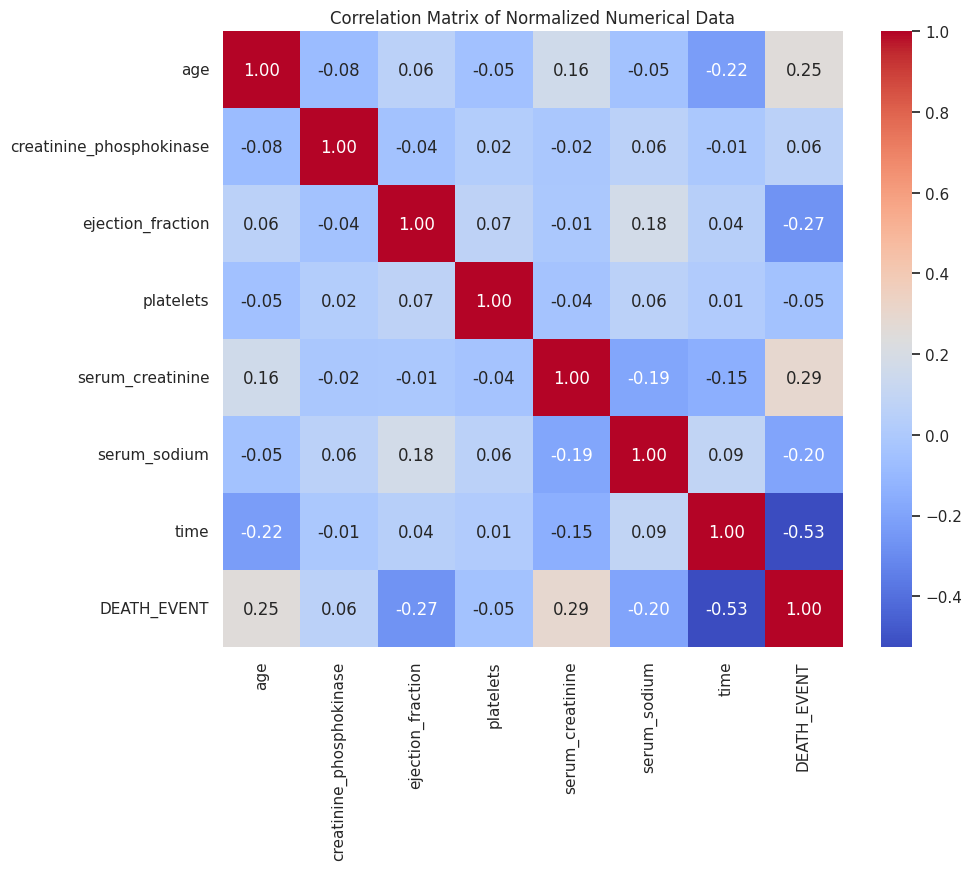

In [183]:
# Z-score normalization
scaler = StandardScaler()
normalized_numerical_data = scaler.fit_transform(numerical_data)
normalized_numerical_data = pd.DataFrame(normalized_numerical_data, columns=numerical_cols)

# Correlation matrix
correlation_matrix = normalized_numerical_data.corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Normalized Numerical Data')
plt.show()

# Interpretation
From the above correlation heat map, we can conclude that :

target and age variable are weakly positively correlated (correlation coefficient = 0.25).

target and cretinine_phosphokinase variable are very  weakly positively correlated (correlation coefficient = 0.06).

target and ejection_fraction variable are weakly negatively correlated (correlation coefficient = -0.27).

target and platelets variable are are very  weakly negatively correlated (correlation coefficient = -0.05).

target and serum_creatinine variable are also mildly positively correlated (correlation coefficient = 0.29).

target and serum_sodium variable are weakly negatively correlated (correlation coefficient = -0.20).

target and time variable are also stronly negatively correlated (correlation coefficient = -0.53).

In [48]:
# Separate features and target
X = data.drop('DEATH_EVENT', axis=1).values
y = data['DEATH_EVENT'].values
feature_names = data.drop('DEATH_EVENT', axis=1).columns.tolist()

# Initial train-test split (70% train, 30% temp for further splitting)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Split the remaining temp set into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to torch tensors and create data loaders
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create datasets for each set
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


# Create data loaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# print the sizes of each set to verify the splits
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 209
Validation set size: 45
Test set size: 45


In [185]:

# CNN Model Definition for Tabular Data with Batch Normalization, Dropout, and Softmax
class TabularCNN(nn.Module):
    def __init__(self, num_features, output_classes=1, dropout_rate=0.5):
        super(TabularCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)

        # Calculate the size of the flattened features after pooling layers
        self.flatten_size = 64 * (num_features // 4)

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout for regularization
        self.fc2 = nn.Linear(64, output_classes)

        # Sigmoid activation for binary classification, softmax for multi-class
        if output_classes == 1:
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout before the final layer
        x = self.fc2(x)
        x = self.activation(x)
        return x

    def predict_proba(self, X):
        self.eval()
        with torch.no_grad():
            X = torch.tensor(X, dtype=torch.float32)
            output = self(X)
            print("Output shape before softmax:", output.shape)  # Add this line
            probabilities = torch.softmax(output, dim=1).numpy()
        return probabilities


# EarlyStopping Class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Model Wrapper for Prediction Probabilities
class ModelWrapper:
    def __init__(self, model):
        self.model = model
        self.model.eval()  # Set evaluation mode

    def predict_proba(self, X):
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X)
            output = self.model(X_tensor)
            return np.column_stack([1 - output.numpy(), output.numpy()])

# Metrics Calculation (Accuracy, Precision, Recall, F1)
def safe_divide(numerator, denominator):
    return numerator / denominator if denominator else 0

def calculate_metrics(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tn = np.sum((y_true == 0) & (y_pred == 0))

    accuracy = safe_divide(tp + tn, tp + tn + fp + fn)
    precision = safe_divide(tp, tp + fp)
    recall = safe_divide(tp, tp + fn)
    f1 = safe_divide(2 * precision * recall, precision + recall)
    return accuracy, precision, recall, f1

# Training Function with EarlyStopping and Learning Rate Scheduler
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler=None, early_stopping=None, epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    best_val_f1 = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss, correct, total = 0.0, 0, 0

        # Training phase
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

        train_accuracy = correct / total
        avg_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_predictions, val_targets = [], []

        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_X, val_y = val_X.to(device), val_y.to(device)
                val_outputs = model(val_X)
                val_loss += criterion(val_outputs, val_y).item()
                val_predicted = (val_outputs > 0.5).float()
                val_total += val_y.size(0)
                val_correct += (val_predicted == val_y).sum().item()
                val_predictions.extend(val_predicted.cpu().numpy())
                val_targets.extend(val_y.cpu().numpy())
                probs = torch.sigmoid(outputs).numpy().squeeze()

        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(test_loader)
        _, _, _, val_f1 = calculate_metrics(np.array(val_targets), np.array(val_predictions))

        print(f"Epoch {epoch+1}/{epochs} - accuracy: {train_accuracy:.4f} - loss: {avg_loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {avg_val_loss:.4f} - F1: {val_f1:.4f}")

        # Step the scheduler if provided
        if scheduler:
            scheduler.step(avg_val_loss)

        # Check for early stopping
        if early_stopping:
            early_stopping(avg_val_loss)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break

        # Save the best model based on validation F1 score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_state)
    return model, best_val_f1

# Hyperparameter Tuning Example
def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    learning_rates = [0.001, 0.01]
    batch_sizes = [32, 64]
    epochs = 50

    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Tuning with lr={lr}, batch_size={batch_size}")
            train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(list(zip(X_val, y_val)), batch_size=batch_size, shuffle=False)

            num_features = X_train.shape[1]
            model = TabularCNN(num_features)

            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = nn.BCELoss()
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
            early_stopping = EarlyStopping(patience=5)

            best_model, best_f1 = train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, early_stopping, epochs)
            print(f"Best validation F1 score: {best_f1:.4f}")

# Instantiate and Train Model Example
def run_training(X_train, y_train, X_val, y_val):
    num_features = X_train.shape[1]
    model = TabularCNN(num_features)

    train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=32, shuffle=True)
    val_loader = DataLoader(list(zip(X_val, y_val)), batch_size=32, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    early_stopping = EarlyStopping(patience=5)

    best_model, best_f1 = train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, early_stopping, epochs=50)
    print(f"Training completed. Best validation F1 score: {best_f1:.4f}")

# Example usage
# X_train, y_train, X_val, y_val should be your dataset split appropriately.
run_training(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor )


Epoch 1/50 - accuracy: 0.6651 - loss: 0.6425 - val_accuracy: 0.7556 - val_loss: 0.5732 - F1: 0.5926
Epoch 2/50 - accuracy: 0.7368 - loss: 0.5406 - val_accuracy: 0.8000 - val_loss: 0.5088 - F1: 0.6897
Epoch 3/50 - accuracy: 0.8086 - loss: 0.4676 - val_accuracy: 0.8000 - val_loss: 0.4481 - F1: 0.6897
Epoch 4/50 - accuracy: 0.8182 - loss: 0.4151 - val_accuracy: 0.8222 - val_loss: 0.4168 - F1: 0.7143
Epoch 5/50 - accuracy: 0.8421 - loss: 0.3589 - val_accuracy: 0.8000 - val_loss: 0.4042 - F1: 0.6667
Epoch 6/50 - accuracy: 0.8756 - loss: 0.3008 - val_accuracy: 0.8000 - val_loss: 0.4346 - F1: 0.5714
Epoch 7/50 - accuracy: 0.9043 - loss: 0.2994 - val_accuracy: 0.7778 - val_loss: 0.4364 - F1: 0.5833
Epoch 8/50 - accuracy: 0.8708 - loss: 0.2704 - val_accuracy: 0.7556 - val_loss: 0.5172 - F1: 0.5217
Epoch 9/50 - accuracy: 0.8900 - loss: 0.2881 - val_accuracy: 0.7333 - val_loss: 0.4797 - F1: 0.5385
Epoch 10/50 - accuracy: 0.9091 - loss: 0.2147 - val_accuracy: 0.7333 - val_loss: 0.4811 - F1: 0.5385

In [186]:
# Define model
num_features = X_train.shape[1]  # Get the number of features in the input data
model = TabularCNN(num_features)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification

# Define learning rate scheduler and early stopping
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
early_stopping = EarlyStopping(patience=5)

# Run the training
best_model, best_f1 = train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, early_stopping, epochs=50)

print(f"Training completed. Best validation F1 score: {best_f1:.4f}")


Epoch 1/50 - accuracy: 0.6411 - loss: 0.6696 - val_accuracy: 0.8222 - val_loss: 0.6295 - F1: 0.7778
Epoch 2/50 - accuracy: 0.7608 - loss: 0.5042 - val_accuracy: 0.7778 - val_loss: 0.4879 - F1: 0.6429
Epoch 3/50 - accuracy: 0.8278 - loss: 0.3753 - val_accuracy: 0.7778 - val_loss: 0.4465 - F1: 0.6429
Epoch 4/50 - accuracy: 0.8182 - loss: 0.4566 - val_accuracy: 0.6667 - val_loss: 0.5518 - F1: 0.5946
Epoch 5/50 - accuracy: 0.8421 - loss: 0.3435 - val_accuracy: 0.8000 - val_loss: 0.3404 - F1: 0.6400
Epoch 6/50 - accuracy: 0.8517 - loss: 0.3484 - val_accuracy: 0.8000 - val_loss: 0.4617 - F1: 0.7097
Epoch 7/50 - accuracy: 0.8804 - loss: 0.2803 - val_accuracy: 0.8222 - val_loss: 0.4135 - F1: 0.6923
Epoch 8/50 - accuracy: 0.8660 - loss: 0.3127 - val_accuracy: 0.7778 - val_loss: 0.4854 - F1: 0.6429
Epoch 9/50 - accuracy: 0.8804 - loss: 0.2778 - val_accuracy: 0.6889 - val_loss: 0.5878 - F1: 0.4167
Epoch 10/50 - accuracy: 0.9043 - loss: 0.2464 - val_accuracy: 0.7333 - val_loss: 0.6043 - F1: 0.4545

In [194]:
# Testing function
def test_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = (outputs > 0.5).float()
        accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Test the model
test_model(model, X_test_tensor, y_test_tensor)

Test Accuracy: 77.78%


In [222]:
def generate_explanations(model, X_train, X_test, feature_names):
    class ModelWrapper:
        def __init__(self, model):
            self.model = model

        def predict_proba(self, X):
            # Convert to numpy array if it's not already
            X = np.array(X)
            # Ensure X is 2D
            if len(X.shape) == 1:
                X = X.reshape(1, -1)

            # Convert to torch tensor
            X_tensor = torch.FloatTensor(X)

            # Set model to eval mode
            self.model.eval()

            with torch.no_grad():
                # Get model outputs
                outputs = self.model(X_tensor)
                # Apply sigmoid to get probabilities (since it's a binary classification)
                probabilities = torch.sigmoid(outputs)
                # Stack probabilities to get the desired format [1-p, p]
                probabilities = torch.cat([1 - probabilities, probabilities], dim=1)

            # Convert to numpy array
            return probabilities.detach().cpu().numpy()

    wrapped_model = ModelWrapper(model)

    # SHAP explanation
    print("Generating SHAP explanations...")
    # Convert to float32 to ensure compatibility
    X_train_float = X_train.astype(np.float32)
    X_test_float = X_test.astype(np.float32)

    # Select background samples
    n_background = min(100, X_train_float.shape[0])
    background_indices = np.random.choice(X_train_float.shape[0], n_background, replace=False)
    background = X_train_float[background_indices]

    # Create explainer and get SHAP values
    explainer = shap.KernelExplainer(wrapped_model.predict_proba, background)
    # Use int instead of np.int
    explainer.expected_value = explainer.expected_value[0]  # Assuming binary classification
    shap_values = explainer.shap_values(X_test_float[:10], l1_reg="num_features(10)")


    # LIME explanation
    print("Generating LIME explanations...")
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train_float,
        feature_names=feature_names,
        class_names=['No Death', 'Death'],
        mode='classification',
        training_labels=None,  # Remove training_labels if not needed
        discretize_continuous=True
    )

    lime_exp = lime_explainer.explain_instance(
        data_row=X_test_float[0],
        predict_fn=wrapped_model.predict_proba,
        num_features=len(feature_names)
    )

    return shap_values, lime_exp

# generate shap explanation function
shap_values, lime_exp = generate_explanations(best_model, X_train, X_test, feature_names)

Generating SHAP explanations...


  0%|          | 0/10 [00:00<?, ?it/s]

Generating LIME explanations...


In [223]:
print(shap_values.shape)
shap_values

(10, 12, 2)


array([[[ 0.00227709, -0.00227709],
        [ 0.00190591, -0.00190591],
        [ 0.00087435, -0.00087435],
        [-0.00392251,  0.00392251],
        [ 0.0031134 , -0.0031134 ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.00048775, -0.00048775],
        [ 0.00350476, -0.00350476],
        [ 0.0011374 , -0.0011374 ],
        [ 0.00613082, -0.00613082],
        [ 0.02457263, -0.02457263]],

       [[ 0.00159289, -0.00159289],
        [ 0.0033307 , -0.0033307 ],
        [ 0.0012302 , -0.0012302 ],
        [-0.00207033,  0.00207033],
        [-0.00586109,  0.00586109],
        [-0.00075604,  0.00075604],
        [ 0.        ,  0.        ],
        [-0.00369908,  0.00369908],
        [-0.00081556,  0.00081556],
        [ 0.        ,  0.        ],
        [ 0.00534952, -0.00534952],
        [-0.0053254 ,  0.0053254 ]],

       [[ 0.        ,  0.        ],
        [ 0.00295986, -0.00295986],
        [ 0.00122683, -0.00122683],
        [-0.0025904 ,  0

In [191]:
print("SHAP values shape:", shap_values.shape)
print("X_test shape:", X_test.shape)
print("Number of feature names:", len(feature_names))

SHAP values shape: (10, 12, 2)
X_test shape: (45, 12)
Number of feature names: 12


In [193]:


def plot_explanations_plotly(shap_values, lime_exp, feature_names, X_test):
    # Reshape SHAP values for the positive class
    shap_values_class1 = shap_values[:, :, 1]  # Taking the positive class

    # Calculate mean absolute SHAP values for feature importance
    feature_importance = np.abs(shap_values_class1).mean(0)

    # Create DataFrame for feature importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    })
    importance_df = importance_df.sort_values('importance', ascending=True)

    # 1. Feature Importance Bar Plot
    fig1 = go.Figure(go.Bar(
        x=importance_df['importance'],
        y=importance_df['feature'],
        orientation='h'
    ))

    fig1.update_layout(
        title='Feature Importance Based on SHAP Values',
        xaxis_title='Mean |SHAP value|',
        yaxis_title='Features',
        height=600,
        width=800,
        showlegend=False
    )
    fig1.show()

    # 2. SHAP Values Violin Plot
    shap_df = pd.DataFrame(shap_values_class1, columns=feature_names)
    shap_melted = shap_df.melt(var_name='Feature', value_name='SHAP Value')

    fig2 = go.Figure()

    for feature in feature_names:
        feature_vals = shap_df[feature]

        fig2.add_trace(go.Violin(
            y=[feature] * len(feature_vals),
            x=feature_vals,
            name=feature,
            orientation='h',
            side='positive',
            meanline_visible=True
        ))

    fig2.update_layout(
        title='SHAP Values Distribution by Feature',
        xaxis_title='SHAP Value',
        yaxis_title='Features',
        height=600,
        width=800,
        showlegend=False
    )
    fig2.show()

    # 3. LIME Explanation Plot
    # Extract LIME explanation data
    lime_features = [exp[0] for exp in lime_exp.as_list()]
    lime_values = [exp[1] for exp in lime_exp.as_list()]

    # Create LIME plot using Plotly
    fig3 = go.Figure(go.Bar(
        x=lime_values,
        y=lime_features,
        orientation='h'
    ))

    fig3.update_layout(
        title='LIME Feature Contributions',
        xaxis_title='Contribution',
        yaxis_title='Features',
        height=600,
        width=800,
        showlegend=False
    )

    # Add a vertical line at x=0 to show positive/negative contributions
    fig3.add_vline(x=0, line_width=1, line_dash="dash", line_color="gray")

    # Update colors based on positive/negative values
    fig3.update_traces(
        marker_color=['red' if x < 0 else 'blue' for x in lime_values]
    )

    fig3.show()

    # 4. Box Plot for SHAP Values Distribution
    fig4 = go.Figure()

    for feature in feature_names:
        fig4.add_trace(go.Box(
            y=shap_df[feature],
            name=feature,
            boxpoints='outliers'
        ))

    fig4.update_layout(
        title='SHAP Values Distribution (Box Plot)',
        yaxis_title='SHAP Value',
        xaxis_title='Features',
        height=600,
        width=800,
        showlegend=False,
        xaxis={'tickangle': 45}
    )
    fig4.show()

# Function to plot feature-SHAP relationship for individual features
def plot_feature_shap_relationship(shap_values, X_test, feature_names, feature_idx):
    feature_name = feature_names[feature_idx]

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=X_test[:, feature_idx],
        y=shap_values[:, feature_idx, 1],  # SHAP values for positive class
        mode='markers',
        marker=dict(
            size=8,
            color=X_test[:, feature_idx],
            colorscale='Viridis',
            showscale=True
        ),
        text=[f'Sample {i}' for i in range(len(X_test))],
        name=feature_name
    ))

    fig.update_layout(
        title=f'SHAP Values vs {feature_name}',
        xaxis_title=f'{feature_name} Value',
        yaxis_title='SHAP Value',
        height=500,
        width=700
    )

    fig.show()

# function call
plot_explanations_plotly(shap_values, lime_exp, feature_names, X_test)


In [202]:
plot_feature_shap_relationship(shap_values, X_test, feature_names, 1)


In [203]:
plot_feature_shap_relationship(shap_values, X_test, feature_names, 0)


In [204]:
plot_feature_shap_relationship(shap_values, X_test, feature_names, 2)


In [205]:
plot_feature_shap_relationship(shap_values, X_test, feature_names, 3)


In [206]:
plot_feature_shap_relationship(shap_values, X_test, feature_names, 4)


In [207]:
plot_feature_shap_relationship(shap_values, X_test, feature_names, 5)


In [208]:
plot_feature_shap_relationship(shap_values, X_test, feature_names, 6)


In [209]:
plot_feature_shap_relationship(shap_values, X_test, feature_names, 7)


In [210]:
plot_feature_shap_relationship(shap_values, X_test, feature_names, 8)


In [211]:
plot_feature_shap_relationship(shap_values, X_test, feature_names, 9)


In [212]:
plot_feature_shap_relationship(shap_values, X_test, feature_names, 10)


In [213]:
plot_feature_shap_relationship(shap_values, X_test, feature_names, 11)


AttributeError: 'LimeTabularExplainer' object has no attribute 'shap_values'